In [1]:
from sklearn.pipeline import * 
from sklearn.naive_bayes import * 
from sklearn.cluster import *  
from sklearn.covariance import *  
from sklearn.cross_decomposition import *  
from sklearn.datasets import *  
from sklearn.decomposition import *  
from sklearn.ensemble import *  
from sklearn.feature_extraction import *  
from sklearn.feature_extraction.text import *  
from sklearn.feature_selection import *  
from sklearn.gaussian_process import *  
from sklearn.linear_model import *  
from sklearn.manifold import *  
from sklearn.metrics import *  
from sklearn.mixture import *  
from sklearn.model_selection import *  
from sklearn.neighbors import *  
from sklearn.neural_network import *  
from sklearn.preprocessing import *  
from sklearn_pandas import DataFrameMapper
from sklearn.svm import *  
from sklearn.tree import *
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tpot import TPOTClassifier

In [4]:
path = r"C:\Users\Sreya\handson\code\data\titanic_train.csv"

In [5]:
titanic = pd.read_csv(path)

In [6]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
titanic.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked'],
      dtype='object')

In [8]:
titanic.shape

(891, 11)

In [9]:
titanic.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [10]:
titanic.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
titanic.columns = titanic.columns.str.strip()

In [12]:
#Filling null values 
round(titanic['age'].mean(),0)
titanic['age'] = titanic['age'].fillna(round(titanic['age'].mean(),0))

In [13]:
#Filling null values 
#titanic['embarked'].value_counts()
titanic['embarked'] = titanic['embarked'].fillna(titanic['embarked'].mode())

In [14]:
titanic['cabin'].value_counts(),titanic['cabin'].nunique()

(cabin
 G6             4
 C23 C25 C27    4
 B96 B98        4
 F2             3
 D              3
               ..
 E17            1
 A24            1
 C50            1
 B42            1
 C148           1
 Name: count, Length: 147, dtype: int64,
 147)

In [15]:
titanic.loc[titanic['cabin'].isna()]['pclass'].value_counts()

pclass
3    479
2    168
1     40
Name: count, dtype: int64

In [16]:
titanic.loc[titanic['cabin'].notna()]['pclass'].value_counts()

pclass
1    176
2     16
3     12
Name: count, dtype: int64

In [17]:
# Taking first letter from Cabin to get Deck
# For each Pclass, getting most common Deck
# Filling missing Deck with that common one
titanic['deck'] = titanic['cabin'].str[0]
titanic['deck'] = titanic['deck'].replace('n', np.nan)
for p_cls in [1, 2, 3]:
    common_deck = titanic[titanic['pclass'] == p_cls]['deck'].mode()[0]
    titanic.loc[(titanic['pclass'] == p_cls) & (titanic['deck'].isna()), 'deck'] = common_deck

In [18]:
titanic['deck'].isna().sum(),titanic['deck'].nunique()

(np.int64(0), 8)

In [19]:
#Renaming target - survived to class
titanic.rename(columns={'survived': 'class'}, inplace=True)


In [20]:
titanic['class'].value_counts()

class
0    549
1    342
Name: count, dtype: int64

In [21]:
titanic.shape

(891, 12)

In [22]:

titanic.nunique()

class         2
pclass        3
name        891
sex           2
age          88
sibsp         7
parch         7
ticket      681
fare        248
cabin       147
embarked      3
deck          8
dtype: int64

In [23]:
titanic.dtypes

class         int64
pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
deck         object
dtype: object

In [24]:
# Loading data into X-->input and y-->output
# Skipping Name and Ticket because they are unique and won't help with prediction
# Ticket would create too many new columns if we use one-hot encoding
# Dropping Cabin because we got the Deck info from it.

X_raw = titanic.loc[:,['pclass','sex','age','sibsp','parch','fare','embarked','deck']]
y = titanic['class']
X_raw.columns

Index(['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'deck'], dtype='object')

In [25]:
#Preprocessing - OneHotEncoding for the job_desig and job_type columns,by dropping originals, and add encoded columns to X_raw
oe = OneHotEncoder(sparse_output = False)  
encoded_columns = oe.fit_transform(X_raw[['sex','embarked','deck']])
encoded_df = pd.DataFrame(encoded_columns, columns=oe.get_feature_names_out(['sex','embarked','deck']))
encoded_df.index = X_raw.index
X_raw = X_raw.drop(columns = ['sex','embarked','deck'])
X_raw = pd.concat([X_raw, encoded_df], axis=1)

In [26]:
scaler = StandardScaler()
X_raw[['pclass', 'age','sibsp','parch','fare']] = scaler.fit_transform(X_raw[['pclass', 'age','sibsp','parch','fare']])

In [27]:
#train-test-split
X_train,X_test,y_train,y_test = train_test_split(X_raw,y,test_size=0.1,random_state=0)

In [28]:
y_train

815    0
877    0
193    1
523    1
634    0
      ..
835    1
192    1
629    0
559    1
684    0
Name: class, Length: 801, dtype: int64

In [29]:
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)  #5 and 100 generations and population_size  atleast in real case
tpot

TPOTClassifier(generations=5, population_size=50, verbosity=2)

In [30]:
tpot.fit(X_train,y_train) 

is_classifier
is_regressor
is_classifier


C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1230: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1270: FutureWarning: passing a class to None is deprecated and will be removed in 1.8. Use an instance of the class instead.
  warnings.warn(


is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier
is_classifier
is_classifier
is_regressor
is_classifier
is_regressor
is_classifier


Version 0.12.2 of tpot is outdated. Version 1.0.0 was released Wednesday February 26, 2025.


Optimization Progress:   1%|▌                                                  | 3/300 [00:33<1:03:57, 12.92s/pipeline]

  File "C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


                                                                                                                       
Generation 1 - Current best internal CV score: 0.8227562111801241
                                                                                                                       
Generation 2 - Current best internal CV score: 0.8240062111801242
                                                                                                                       
Generation 3 - Current best internal CV score: 0.8351940993788819
                                                                                                                       
Generation 4 - Current best internal CV score: 0.8351940993788819
                                                                                                                       
Generation 5 - Current best internal CV score: 0.8351940993788819
                                                                      

TPOTClassifier(generations=5, population_size=50, verbosity=2)

In [31]:
tpot.score(X_train,y_train)

C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.9188514357053683

In [32]:
tpot.score(X_train,y_train)

C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


0.9188514357053683

In [33]:
tpot.export("tpot_titanic_pipe.py")

In [34]:
y_train_pred = tpot.predict(X_train)
confusion_matrix(y_train,y_train_pred)

C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([[477,  21],
       [ 44, 259]])

C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

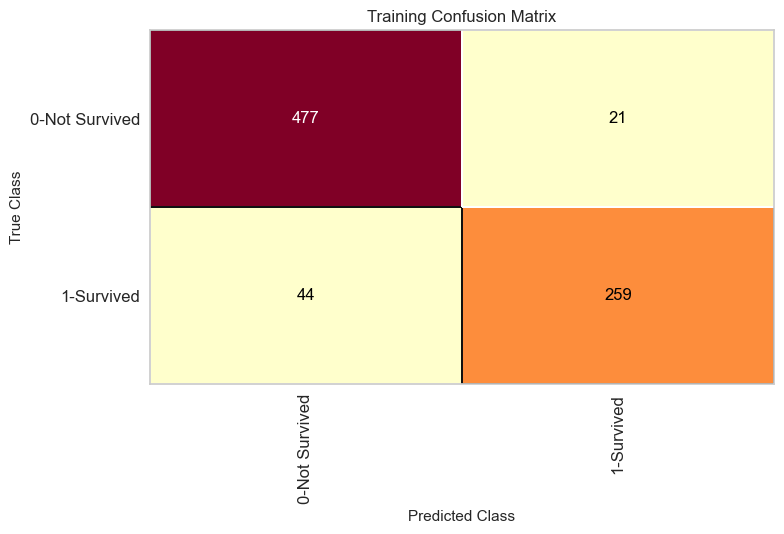

<Axes: title={'center': 'Training Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [35]:
classes = ['0-Not Survived','1-Survived']
cm = ConfusionMatrix(tpot,classes=classes,title='Training Confusion Matrix')
cm.score(X_train,y_train)
cm.show()

C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Sreya\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\

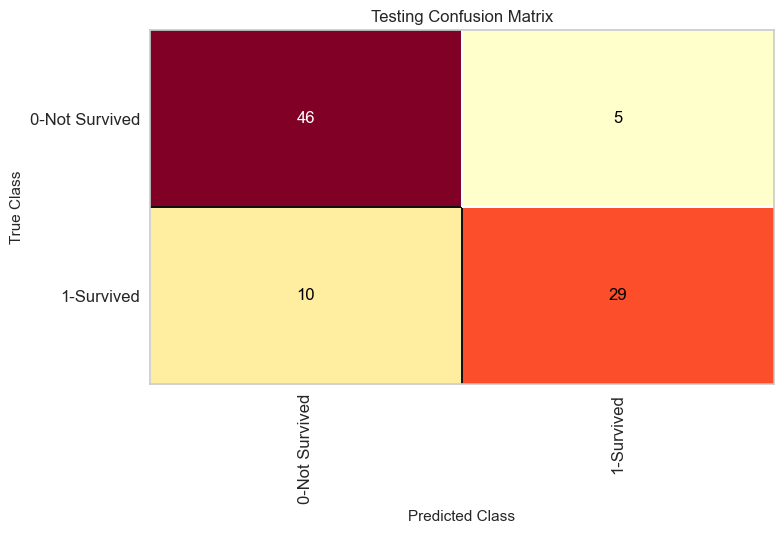

<Axes: title={'center': 'Testing Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [36]:
classes = ['0-Not Survived','1-Survived']
cm = ConfusionMatrix(tpot,classes=classes,title='Testing Confusion Matrix')
cm.score(X_test,y_test)
cm.show()

In [37]:
%pycat tpot_titanic_pipe.py

import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8351940993788819
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.1, max_depth=4, max_features=0.8500000000000001, min_samples_leaf=3, min_samples_split=11, n_estimators=100, subsample=0.5)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_f

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=None)

# Average CV score on the training set was: 0.8327329192546584
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.35000000000000003, min_samples_leaf=15, min_samples_split=3, n_estimators=100, subsample=0.8500000000000001)),
    ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.4, min_samples_leaf=15, min_samples_split=9, n_estimators=100)
)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)